# Some imports and helper code

In [112]:
import pickle
import seaborn
import numpy as np
import pandas as pd
import scipy as sci
import networkx as nx
import matplotlib.pylab as plt
np.random.seed(1)

%matplotlib inline 
%load_ext autoreload

plt.style.use('seaborn-paper')
seaborn.set_context('paper', font_scale=2.2)
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.weight'] = 'medium'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
def plot_results(results, alphas):
    plt.figure()
    results[['lambda', 'lambda_sub', 'centrality']].plot(kind='line')
    plt.xlabel('iterations')
    title_template = r'$\alpha_1={:.2f}, \alpha_2={:.2f}, \alpha_3={:.2f}$'
    plt.title(title_template.format(*alphas))
    
    
def plot_adj_matrices(A, attacked_A):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(A, cmap='hot')
    axes[0].set_title('before attack')
    axes[1].imshow(attacked_A, cmap='hot')
    axes[1].set_title('after attack')

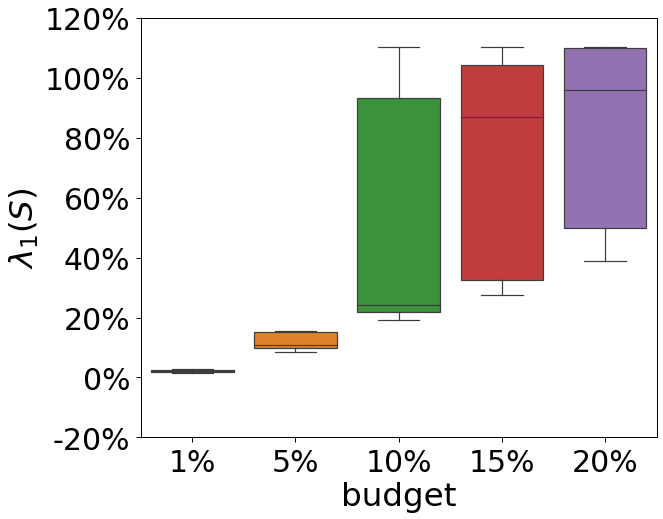

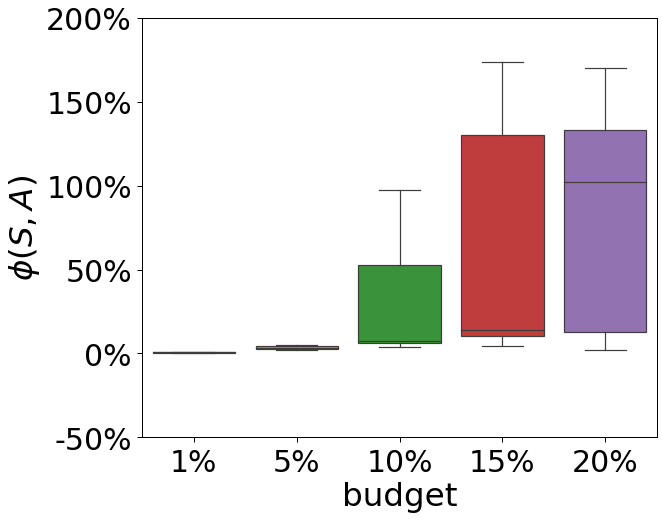

In [131]:
graph_type = 'BTER'
with open('../result/{}_numExp_15.p'.format(graph_type), 'rb') as fid:
    data = pickle.load(fid)

data_f = []
for budget in data.keys():
    for item in data[budget]:
        data_f.append([item[1], item[2], budget])
data_f = pd.DataFrame(data_f, columns=['lambda1_S', 'centrality', 'budget'], dtype=np.float32)        
data_f = data_f.dropna()

seaborn.set_context('paper', font_scale=3.4)
plt.subplots(figsize=(10, 8))
ax = seaborn.boxplot(x='budget', y='lambda1_S', data=data_f, orient='v', showfliers=False)
plt.xticks(range(5), ['1%', '5%', '10%', '15%', '20%'])
plt.yticks(ax.get_yticks(),  ['%.0f%%' % (i*100) for i in ax.get_yticks()])
plt.ylabel('$\lambda_1(S)$')
plt.xlabel('budget')
plt.tight_layout()
# plt.title("% of increases $\lambda_1(S)$ - {}".format(graph_type))
plt.savefig('../result/figure/{}_lambda1S_numExp_15.pdf'.format(graph_type))


seaborn.set_context('paper', font_scale=3.4)
plt.subplots(figsize=(10, 8))
ax = seaborn.boxplot(x='budget', y='centrality', data=data_f, orient='v', showfliers=False)
plt.xticks(range(5), ['1%', '5%', '10%', '15%', '20%'])
plt.yticks(ax.get_yticks(),  ['%.0f%%' % (i*100) for i in ax.get_yticks()])
plt.ylabel('$\phi(S, A)$')
plt.tight_layout()
# plt.title("% of increases cut(S) - {}".format(graph_type))
plt.savefig('../result/figure/{}_cut_numExp_15.pdf'.format(graph_type))

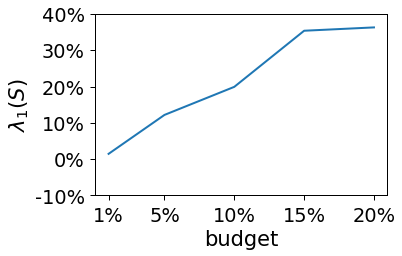

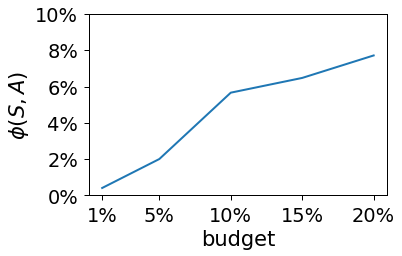

In [120]:
graph_type = 'Email'
cc = 50
with open('../result/{}_numExp_1_cc={}.p'.format(graph_type, cc), 'rb') as fid:
    data = pickle.load(fid)
    
data_f = []
for budget in data.keys():
    for item in data[budget]:
        data_f.append([item[1], item[2], budget])
data_f = pd.DataFrame(data_f, columns=['lambda1_S', 'centrality', 'budget'], dtype=np.float32)        
data_f = data_f.dropna()

plt.figure()
plt.plot(data_f['budget'], data_f['lambda1_S'], linewidth=2)
ax = plt.gca()
plt.xticks([0.01, 0.05, 0.1, 0.15, 0.2], ['1%', '5%', '10%', '15%', '20%'])
plt.yticks(ax.get_yticks(),  ['%.0f%%' % (i*100) for i in ax.get_yticks()])
plt.ylabel('$\lambda_1(S)$')
plt.xlabel('budget')
plt.tight_layout()
plt.savefig('../result/figure/{}_lambda1S_cc={}.pdf'.format(graph_type, cc))

plt.figure()
plt.plot(data_f['budget'], data_f['centrality'],linewidth=2)
ax = plt.gca()
plt.xticks([0.01, 0.05, 0.1, 0.15, 0.2], ['1%', '5%', '10%', '15%', '20%'])
plt.yticks(ax.get_yticks(),  ['%.0f%%' % (i*100) for i in ax.get_yticks()])
plt.ylabel('$\phi(S, A)$')
plt.xlabel('budget')
plt.tight_layout()
plt.savefig('../result/figure/{}_cut_cc={}.pdf'.format(graph_type, cc))